In [126]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from scipy import stats
from genel_fonk import *
from sklearn.cluster import AgglomerativeClustering

In [96]:
df=pd.read_csv("flo_data_20k.csv")

In [97]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [98]:
df.isnull().sum()

master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_in_categories_12          0
dtype: int64

In [99]:
check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App    

In [100]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0,3.110855,4.225647,1.00,1.00,2.00,4.00,200.00
order_num_total_ever_offline,19945.0,1.913913,2.062880,1.00,1.00,1.00,2.00,109.00
customer_value_total_ever_offline,19945.0,253.922597,301.532853,10.00,99.99,179.98,319.97,18119.14
customer_value_total_ever_online,19945.0,497.321690,832.601886,12.99,149.98,286.46,578.44,45220.13


In [101]:
missing_values_table(df,na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

In [102]:
# tarih değişkenine çevirme
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

df["last_order_date"].max() # 2021-05-30
analysis_date = dt.datetime(2021,6,1)

df["recency"] = (analysis_date - df["last_order_date"]).dt.days
df["tenure"] = (df["last_order_date"] - df["first_order_date"]).dt.days


In [103]:
model_df = df[["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.0,1.0,139.99,799.38,95,119
1,19.0,2.0,159.97,1853.58,105,1469
2,3.0,2.0,189.97,395.35,186,366
3,1.0,1.0,39.99,81.98,135,11
4,1.0,1.0,49.99,159.99,86,582


In [104]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column],color = "g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

order_num_total_ever_online's: Skew: 10.487693811914617, : SkewtestResult(statistic=152.9996121784795, pvalue=0.0)
order_num_total_ever_offline's: Skew: 20.328068075845888, : SkewtestResult(statistic=184.13121810134328, pvalue=0.0)


C:\Users\baros\AppData\Local\Temp\ipykernel_6472\4200321661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
C:\Users\baros\AppData\Local\Temp\ipykernel_6472\4200321661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
C:\Users\baros

customer_value_total_ever_offline's: Skew: 16.29952194789334, : SkewtestResult(statistic=173.73456097827923, pvalue=0.0)
customer_value_total_ever_online's: Skew: 20.08427979804232, : SkewtestResult(statistic=183.56317267711924, pvalue=0.0)


C:\Users\baros\AppData\Local\Temp\ipykernel_6472\4200321661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
C:\Users\baros\AppData\Local\Temp\ipykernel_6472\4200321661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")


recency's: Skew: 0.6172488156761073, : SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)
tenure's: Skew: 1.756242119042335, : SkewtestResult(statistic=71.08790370222574, pvalue=0.0)


C:\Users\baros\AppData\Local\Temp\ipykernel_6472\4200321661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")


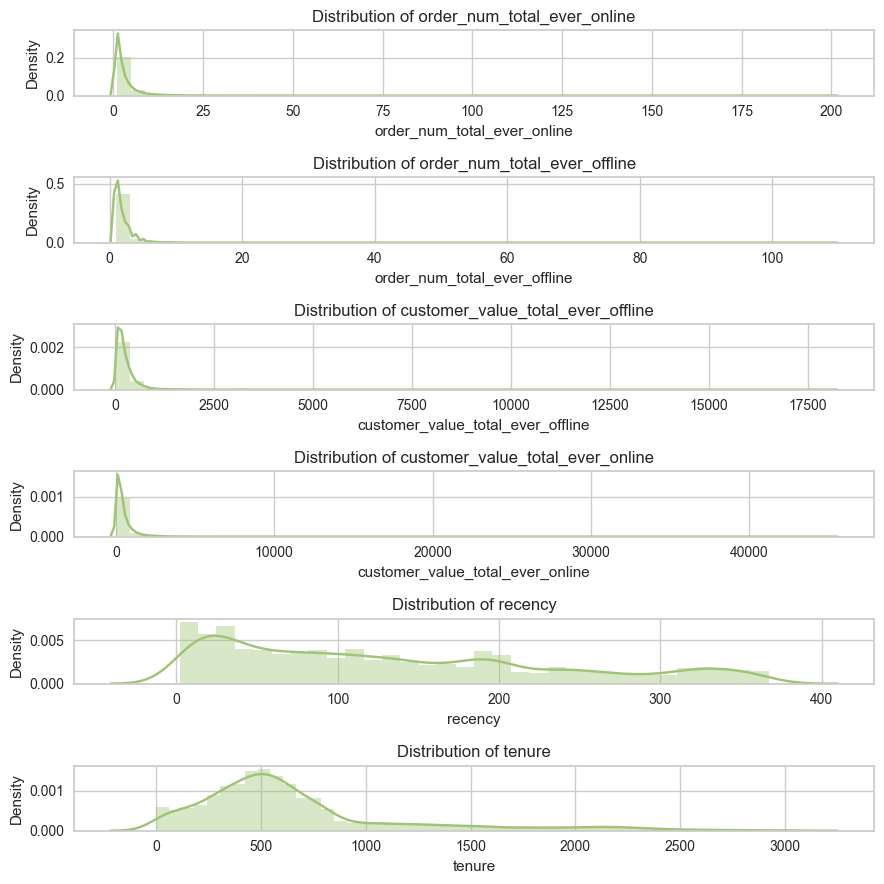

In [105]:

plt.figure(figsize=(9, 9))
plt.subplot(6, 1, 1)
check_skew(model_df,'order_num_total_ever_online')
plt.subplot(6, 1, 2)
check_skew(model_df,'order_num_total_ever_offline')
plt.subplot(6, 1, 3)
check_skew(model_df,'customer_value_total_ever_offline')
plt.subplot(6, 1, 4)
check_skew(model_df,'customer_value_total_ever_online')
plt.subplot(6, 1, 5)
check_skew(model_df,'recency')
plt.subplot(6, 1, 6)
check_skew(model_df,'tenure')
plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)
plt.show()

In [106]:
# Normal dağılımın sağlanması için Log transformation uygulanması
model_df['order_num_total_ever_online']=np.log1p(model_df['order_num_total_ever_online'])
model_df['order_num_total_ever_offline']=np.log1p(model_df['order_num_total_ever_offline'])
model_df['customer_value_total_ever_offline']=np.log1p(model_df['customer_value_total_ever_offline'])
model_df['customer_value_total_ever_online']=np.log1p(model_df['customer_value_total_ever_online'])
model_df['recency']=np.log1p(model_df['recency'])
model_df['tenure']=np.log1p(model_df['tenure'])
model_df.head()

C:\Users\baros\AppData\Local\Temp\ipykernel_6472\920670875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['order_num_total_ever_online']=np.log1p(model_df['order_num_total_ever_online'])
C:\Users\baros\AppData\Local\Temp\ipykernel_6472\920670875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['order_num_total_ever_offline']=np.log1p(model_df['order_num_total_ever_offline'])
C:\Users\baros\AppData\Local\Temp\ipykernel_6472\920670875.py:4: SettingWithCopyWarning: 
A value is trying 

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.609438,0.693147,4.948689,6.685087,4.564348,4.787492
1,2.995732,1.098612,5.081218,7.525414,4.663439,7.293018
2,1.386294,1.098612,5.252116,5.982298,5.231109,5.905362
3,0.693147,0.693147,3.713328,4.418600,4.912655,2.484907
4,0.693147,0.693147,3.931630,5.081342,4.465908,6.368187


In [107]:
sc=MinMaxScaler((0,1))
model_scaling = sc.fit_transform(model_df)


In [108]:
model_df=pd.DataFrame(model_scaling,columns=model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.198755,0.000000,0.344381,0.500774,0.720607,0.597095
1,0.499459,0.101181,0.362274,0.604762,0.741210,0.909584
2,0.150352,0.101181,0.385347,0.413806,0.859241,0.736516
3,0.000000,0.000000,0.177596,0.220302,0.793028,0.309917
4,0.000000,0.000000,0.207069,0.302315,0.700139,0.794240


In [109]:
kmeans = KMeans()

In [110]:
elbow = KElbowVisualizer(kmeans, k=(2, 20))

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=19), k=(2, 20))

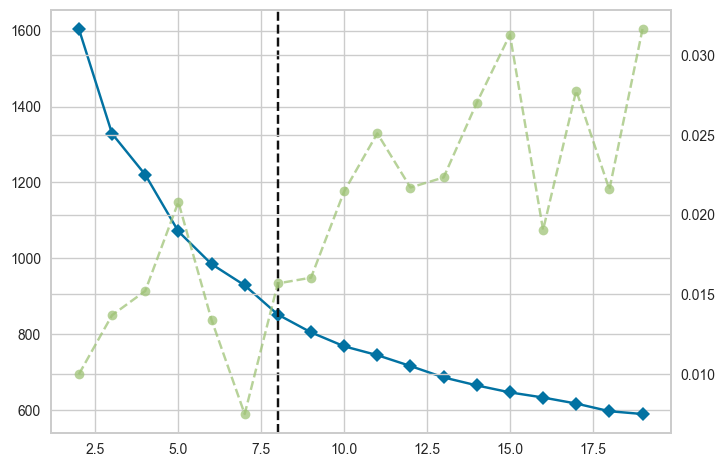

In [111]:
elbow.fit(model_df)

In [112]:
elbow.show()

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [113]:
k_means = KMeans(n_clusters = 7, random_state= 42).fit(model_df)

In [114]:
segments=k_means.labels_

In [115]:
segments

array([3, 3, 3, ..., 4, 5, 0])

In [116]:
final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]

In [117]:
final_df["segment"] = segments


C:\Users\baros\AppData\Local\Temp\ipykernel_6472\1480026114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["segment"] = segments


In [118]:
final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.0,1.0,139.99,799.38,95,119,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.0,2.0,159.97,1853.58,105,1469,3
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.0,2.0,189.97,395.35,186,366,3
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.0,1.0,39.99,81.98,135,11,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.0,1.0,49.99,159.99,86,582,2


In [119]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online             order_num_total_ever_offline  \
                               mean  min    max                         mean   
segment                                                                        
0                          1.429881  1.0    5.0                     1.276994   
1                          1.404358  1.0    8.0                     1.129540   
2                          1.610099  1.0    6.0                     1.475949   
3                          6.459710  1.0   55.0                     1.556653   
4                          2.153468  1.0   11.0                     2.099945   
5                          1.825107  1.0   13.0                     3.758379   
6                          8.570483  2.0  200.0                     2.092621   

                    customer_value_total_ever_offline                    \
         min    max                              mean     min       max   
segment                                                                   
0        1.0    5.0                        144.508236   10.00    829.98   
1        1.0    6.0                        192.605872   12.99   1333.00   
2        1.0    6.0                        185.291900   12.99   1406.85   
3        1.0   16.0                        187.031494   10.49   1644.79   
4        1.0   14.0                        293.957712   12.99   3425.14   
5        1.0  109.0                        549.820905  106.82  18119.14   
6        1.0   36.0                        279.076611   12.99   3589.65   

        customer_value_total_ever_online                       recency      \
                                    mean     min       max        mean min   
segment                                                                      
0                             211.857052   12.99   1519.17  226.270394  88   
1                             250.505363   19.99   3476.81  139.346247   4   
2                             249.821873   14.00   1307.33   50.685987  15   
3                             998.039361  180.96  12038.18  178.338376  55   
4                             369.081644   23.99   3444.08   10.075369   2   
5                             281.821926   14.99   2587.20  153.615174  22   
6                            1469.186824  265.97  45220.13   31.791349   2   

                  tenure                  
         max        mean min   max count  
segment                                   
0        367  490.580018  52  2820  5455  
1        367   37.027845   0   132   826  
2        109  604.318793  51  2828  3347  
3        367  948.187095  26  2964  3239  
4         27  660.213545   2  2962  1831  
5        366  728.578001  20  2911  3282  
6        109  966.736387  18  3034  1965

# Hierarchical Cluster

In [124]:
hc_complete = linkage(model_df, 'complete')

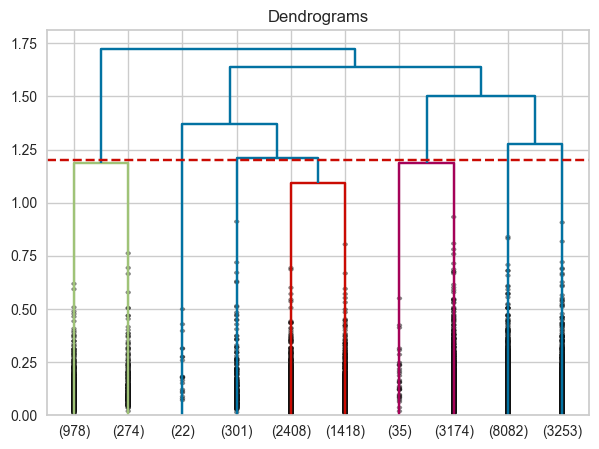

In [125]:
plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=1.2, color='r', linestyle='--')
plt.show()


In [128]:
hc = AgglomerativeClustering(n_clusters=6)
segments = hc.fit_predict(model_df)

In [129]:
final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = segments
final_df.head()

C:\Users\baros\AppData\Local\Temp\ipykernel_6472\2142485556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["segment"] = segments


,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.0,1.0,139.99,799.38,95,119,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.0,2.0,159.97,1853.58,105,1469,2
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.0,2.0,189.97,395.35,186,366,1
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.0,1.0,39.99,81.98,135,11,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.0,1.0,49.99,159.99,86,582,5


In [130]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})


order_num_total_ever_online             order_num_total_ever_offline  \
                               mean  min    max                         mean   
segment                                                                        
0                          3.753905  1.0   49.0                     1.816980   
1                          1.401700  1.0   13.0                     2.193057   
2                          6.905676  1.0  200.0                     3.077212   
3                          1.396954  1.0    6.0                     1.198985   
4                          4.741056  1.0   24.0                     1.118668   
5                          1.315382  1.0    4.0                     1.613995   

                    customer_value_total_ever_offline                   \
         min    max                              mean    min       max   
segment                                                                  
0        1.0   24.0                        240.983644  12.99   3425.14   
1        1.0  109.0                        293.628365  10.49  18119.14   
2        1.0   16.0                        427.118293  12.99   2963.24   
3        1.0    6.0                        200.690721  12.99   1019.97   
4        1.0    4.0                        123.463450  10.00   1049.92   
5        1.0    5.0                        204.319581  10.99   1419.98   

        customer_value_total_ever_online                       recency      \
                                    mean     min       max        mean min   
segment                                                                      
0                             638.613773   19.99  12545.37   23.962155   2   
1                             222.682118   12.99  30688.47  229.926674  33   
2                            1104.124578  139.98  45220.13  131.573873  14   
3                             227.424061   26.99   1389.60   92.515736   4   
4                             722.767938   59.98   7665.28  196.523557  36   
5                             181.461338   14.00   1307.33   97.637536  18   

                  tenure                   
         max        mean  min   max count  
segment                                    
0        108  715.065679   18  3034  4994  
1        367  501.811194    3  2820  5646  
2        365  914.487062  109  3016  2396  
3        367   80.257868    0   555   985  
4        367  876.953950   71  2964  2823  
5        322  693.370848  108  2911  3101